In [ ]:
"""
AI-Powered Biomedical Image Search Using CLIP & PathMNIST

-search engine that retrieves relevant medical images using natural language.

Features:
- Text-to-Image search ("show me lung X-rays")
- Image-to-Image search (find similar figures)
- Uses CLIP for cross-modal embeddings
- Lightweight: runs on 8GB RAM
"""

'\nAI-Powered Biomedical Image Search Using CLIP & PathMNIST\n\n-search engine that retrieves relevant medical images using natural language.\n\nFeatures:\n- Text-to-Image search ("show me lung X-rays")\n- Image-to-Image search (find similar figures)\n- Uses CLIP for cross-modal embeddings\n- Lightweight: runs on 8GB RAM\n'

In [ ]:
print("🔧 Installing dependencies")

!pip install -q sentence-transformers
!pip install -q datasets
!pip install -q pillow matplotlib scikit-learn

print("All packages installed!")

🔧 Installing dependencies
All packages installed!


In [ ]:
# Cell 2: Import all libraries
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import warnings
import requests
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"Running on: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.9.0+cu126
Running on: CPU


In [ ]:
# Cell 3: Load the CLIP model

model = SentenceTransformer('clip-ViT-B-32')

print("Model loaded successfully!")
print(f"   Embedding size: {model.get_sentence_embedding_dimension()} dimensions")

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded successfully!
   Embedding size: None dimensions


In [ ]:
# Cell 4: Load medical images dataset (100 images for sample search)

url = "https://zenodo.org/record/5208230/files/pathmnist.npz?download=1"
save_path = "pathmnist.npz"


print("Downloading PathMNIST dataset from Zenodo…")

r = requests.get(url)

with open(save_path, "wb") as f:
    f.write(r.content)

print("Download complete.")



Download complete.


In [8]:
data = np.load("pathmnist.npz")

x_train = data["train_images"]
y_train = data["train_labels"].flatten()

print("Train set:", x_train.shape, y_train.shape)

# Use only 100 images for the search system
images_data = x_train[:100]
labels = y_train[:100]

label_names = [
    "adipose",
    "background",
    "debris",
    "lymphocytes",
    "mucus",
    "smooth_muscle",
    "normal_colon_mucosa",
    "cancer_associated_stroma",
    "colorectal_adenocarcinoma"
]

print("Loaded first 100 PathMNIST images")


Train set: (89996, 28, 28, 3) (89996,)
Loaded first 100 PathMNIST images


Displaying sample medical images...


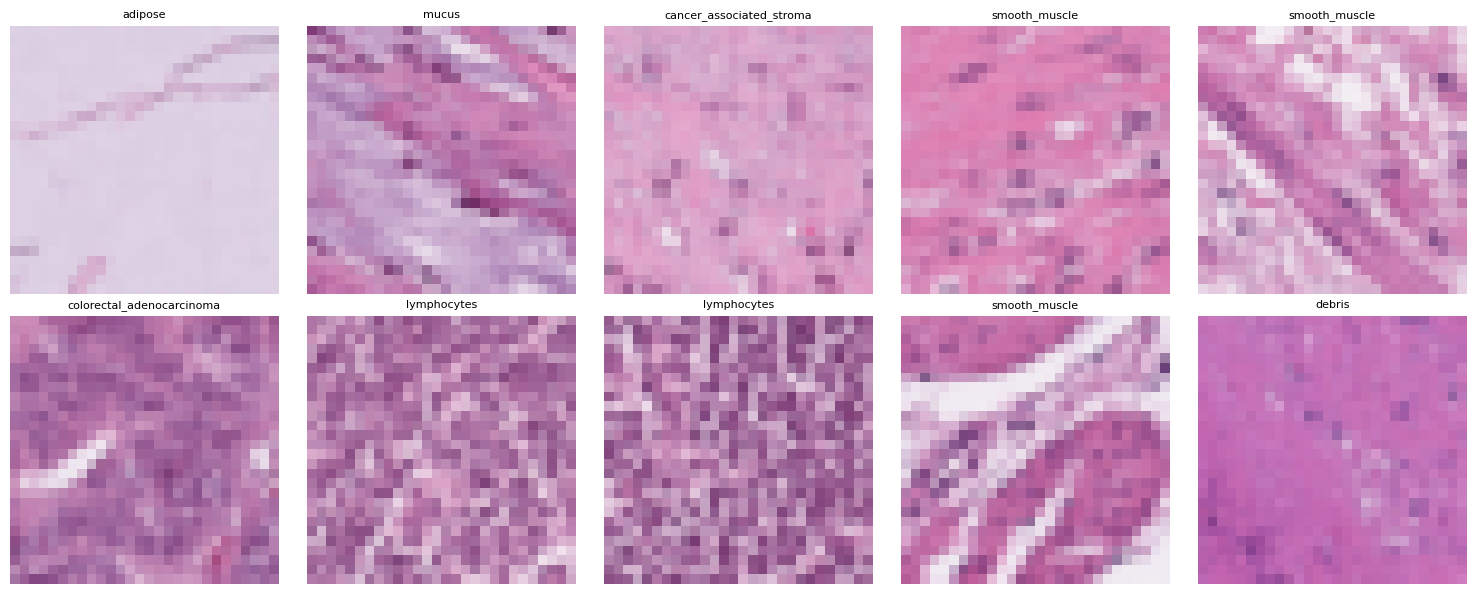

In [9]:
print("Displaying sample medical images...")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(images_data[i])
    ax.set_title(label_names[labels[i]], fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
print("Generating embeddings for 100 images...")

# Convert numpy images → PIL images
pil_images = [Image.fromarray(img) for img in images_data]

image_embeddings = model.encode(
    pil_images,
    convert_to_tensor=True,
    batch_size=16,
    show_progress_bar=True
)

print("Embeddings generated!", image_embeddings.shape)


Generating embeddings for 100 images...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Embeddings generated! torch.Size([100, 512])


In [13]:
def search_images_by_text(query, top_k=5):
    query_emb = model.encode(query, convert_to_tensor=True)
    sims = util.cos_sim(query_emb, image_embeddings)[0]
    top = torch.topk(sims, k=top_k)

    results = [(i.item(), s.item()) for i, s in zip(top.indices, top.values)]
    return results

print("Text search function ready!")


Text search function ready!


In [12]:
def display_results(results, query=None):
    n = len(results)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))

    if n == 1:
        axes = [axes]

    fig.suptitle(f"🔍 Search: '{query}'" if query else "Similar Images", fontsize=14)

    for ax, (idx, score) in zip(axes, results):
        ax.imshow(images_data[idx])
        ax.set_title(f"{label_names[labels[idx]]}\nScore: {score:.3f}", fontsize=10)
        ax.axis("off")

    plt.show()

print("Display function ready!")


Display function ready!


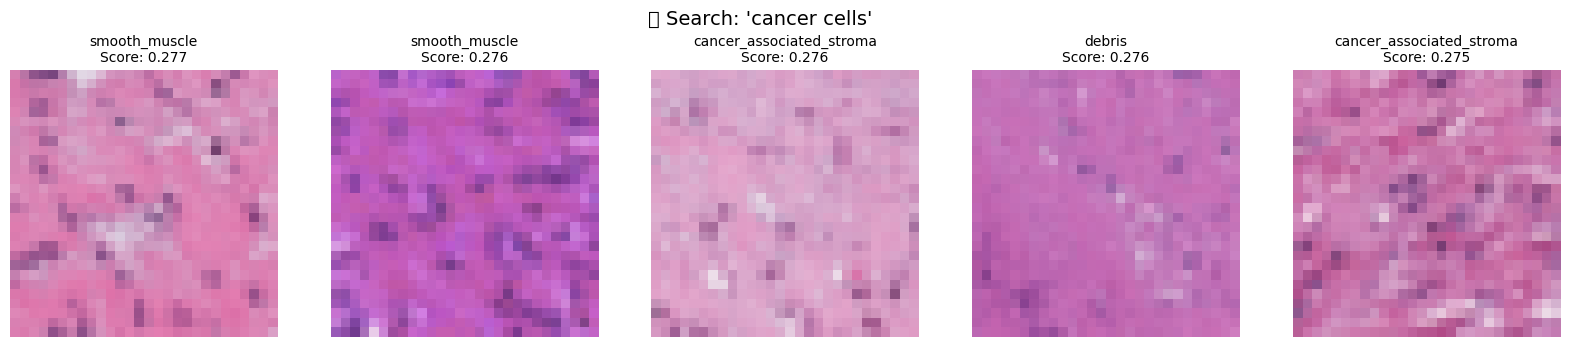

In [ ]:
query = "cancer cells"
results = search_images_by_text(query)
display_results(results, query)

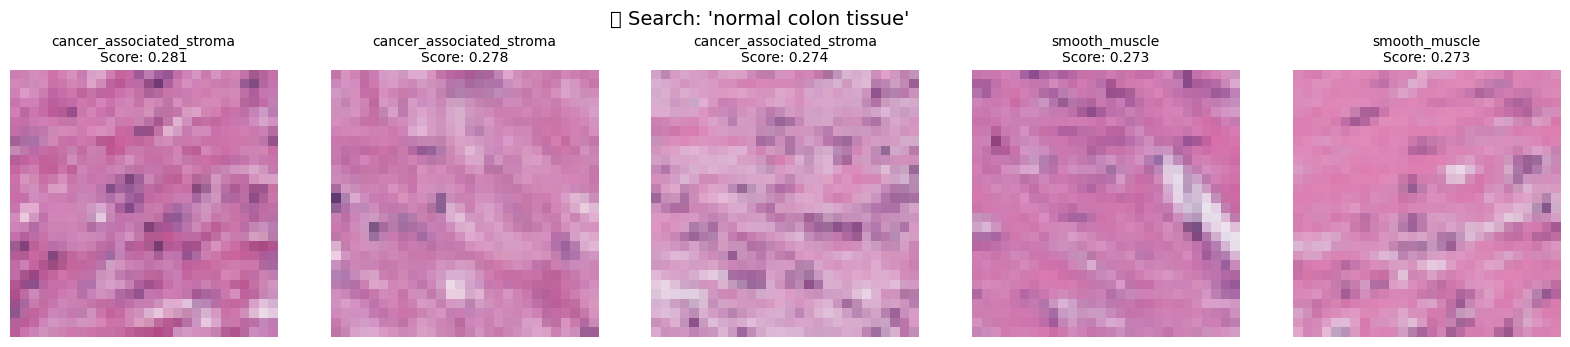

In [ ]:
query = "normal colon tissue"
results = search_images_by_text(query)
display_results(results, query)



 Query: immune cells lymphocytes


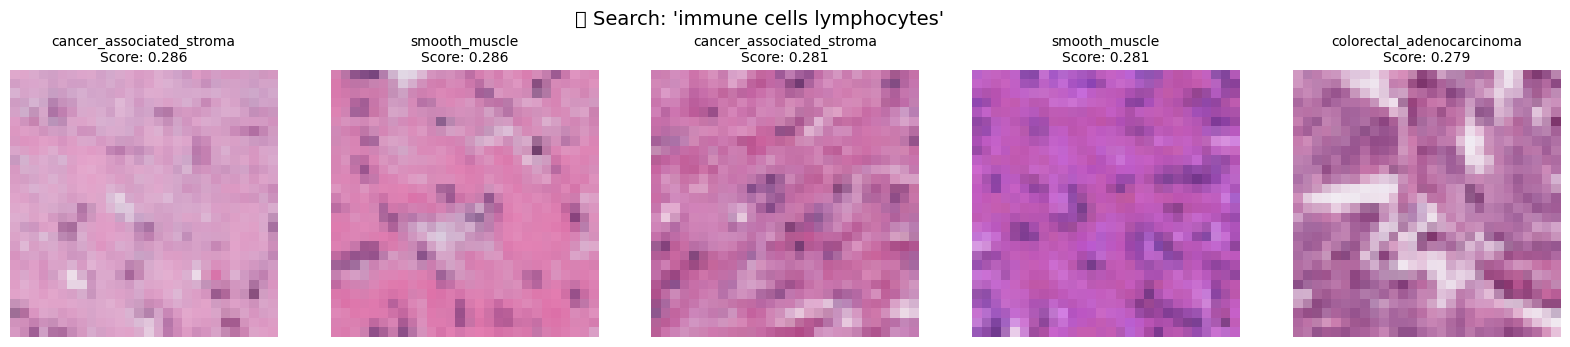


 Query: smooth muscle tissue


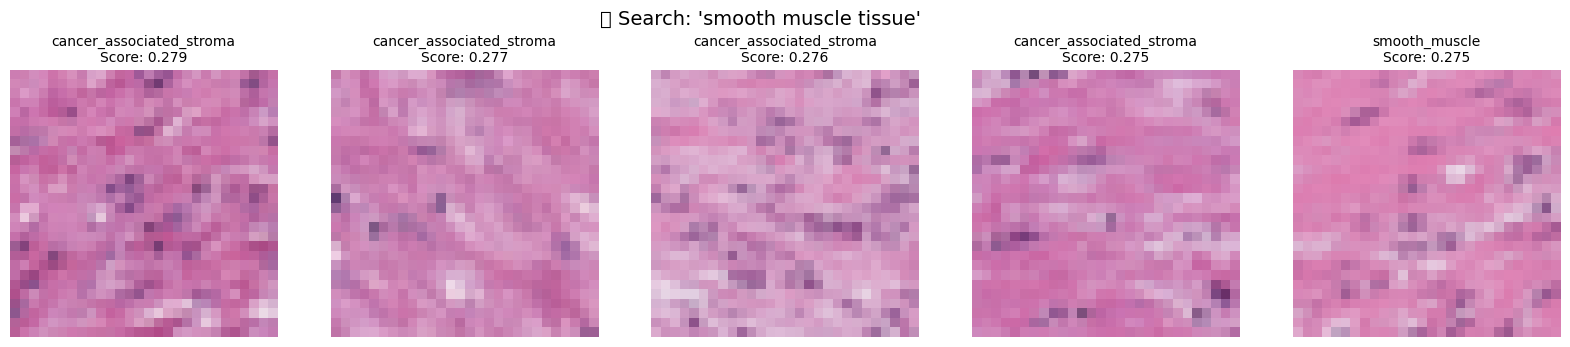


 Query: colorectal adenocarcinoma


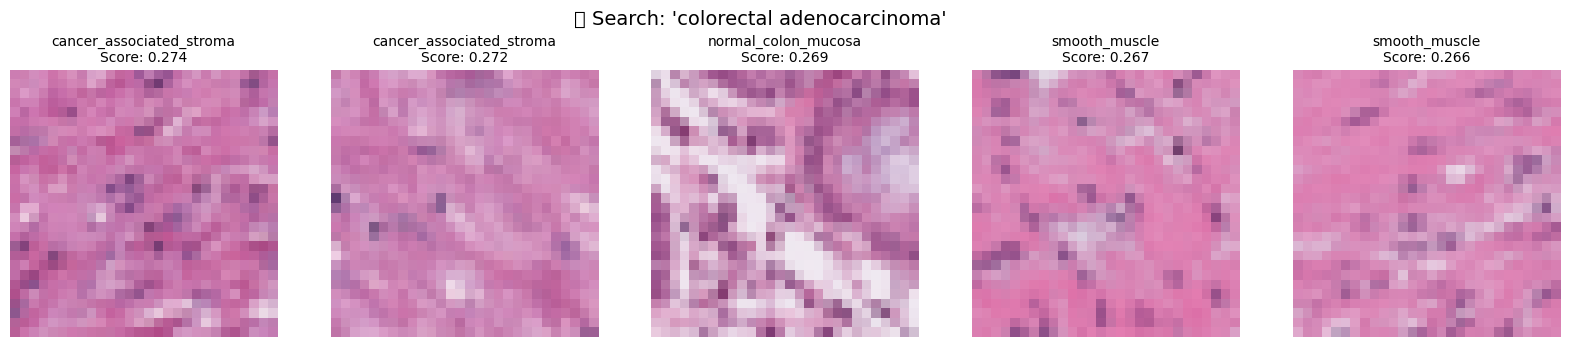

In [14]:
test_queries = [
    "immune cells lymphocytes",
    "smooth muscle tissue",
    "colorectal adenocarcinoma"
]

for q in test_queries:
    print(f"\n Query: {q}")
    results = search_images_by_text(q)
    display_results(results, q)


Query: background


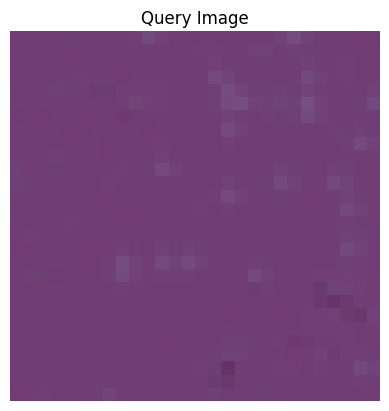

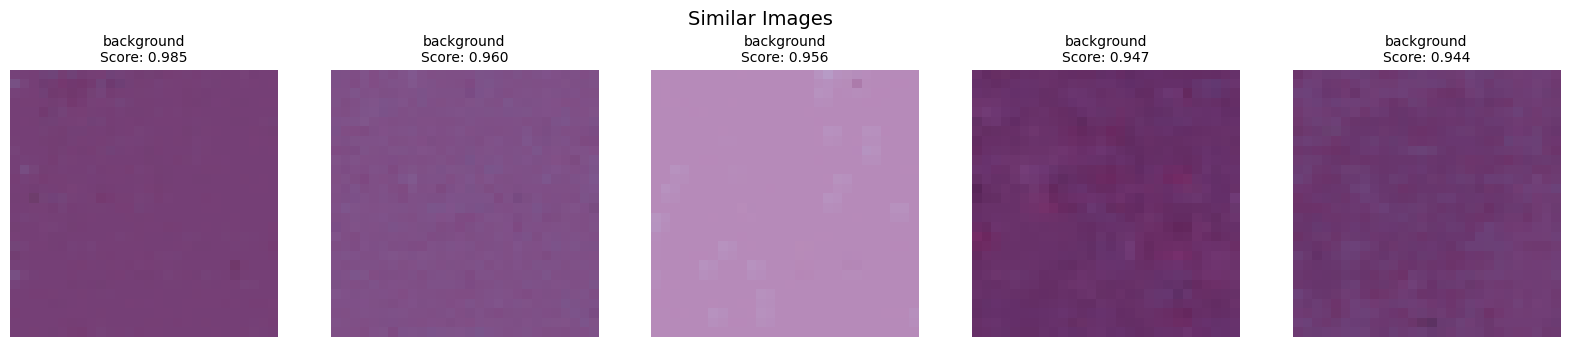

In [ ]:
query_idx = 15
query_emb = image_embeddings[query_idx]

sims = util.cos_sim(query_emb, image_embeddings)[0]
top = torch.topk(sims, k=6)

results = [(i.item(), s.item()) for i, s in zip(top.indices, top.values) if i != query_idx][:5]

print("Query:", label_names[labels[query_idx]])
plt.imshow(images_data[query_idx])
plt.title("Query Image")
plt.axis("off")
plt.show()

display_results(results)


In [19]:
def calculate_accuracy(k=5):
    correct = 0
    N = len(image_embeddings)

    for idx in range(N):
        label = labels[idx]
        emb = image_embeddings[idx]

        sims = util.cos_sim(emb, image_embeddings)[0]
        top = torch.topk(sims, k=k+1).indices

        for j in top:
            j = j.item()
            if j != idx and labels[j] == label:
                correct += 1
                break

    return 100 * correct / N

acc = calculate_accuracy()
acc


91.0

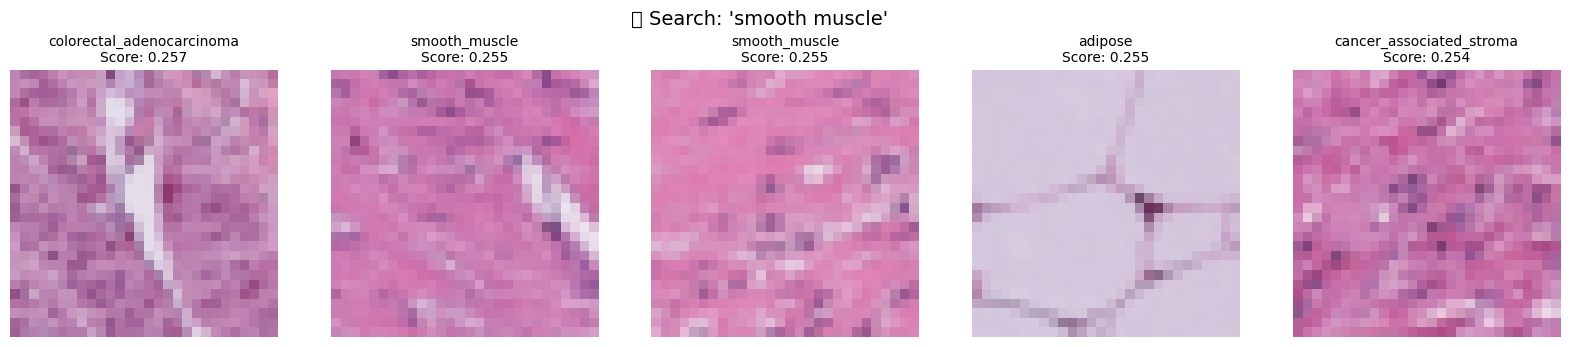

In [ ]:
YOUR_QUERY = "smooth muscle"

results = search_images_by_text(YOUR_QUERY)
display_results(results, YOUR_QUERY)


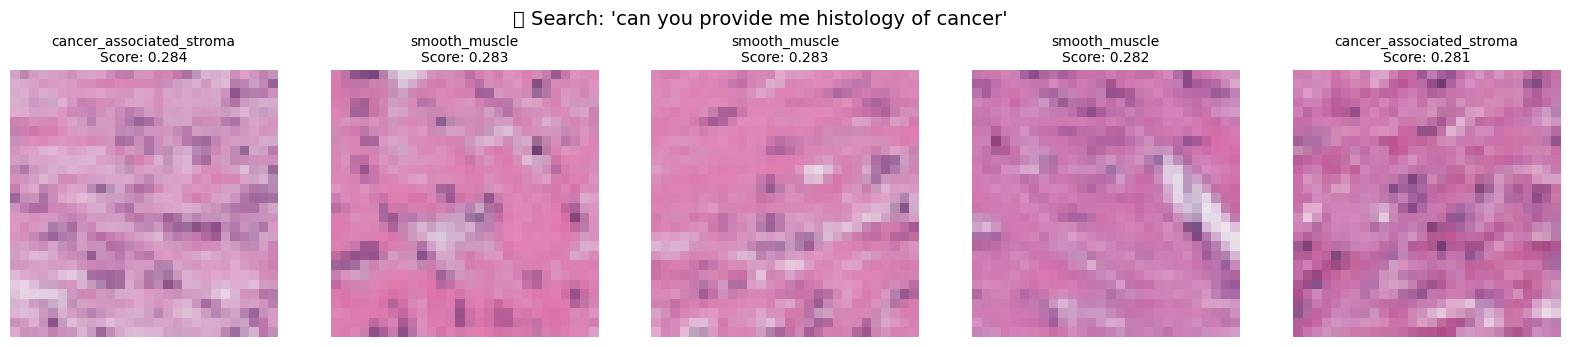

In [17]:
YOUR_QUERY = "can you provide me histology of cancer"

results = search_images_by_text(YOUR_QUERY)
display_results(results, YOUR_QUERY)

In [20]:

print(f"Indexed images: {len(images_data)}")
print(f"Embedding dimension: {image_embeddings.shape[1]}")
print(f"Top-5 accuracy: {acc:.1f}%")


Indexed images: 100
Embedding dimension: 512
Top-5 accuracy: 91.0%
